In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from scipy.integrate import solve_ivp
import statistics
import seaborn as sns
from matplotlib.pyplot import figure
import imageio
import os

C:\Users\nessl\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def syst(t,z,param):
    
    Pa,C,GC,GCT,Tc,Tuc,Pi,G = z
    
    Kcdiss,Kcbind,Kcrdiss,Kcrbind,g,Ksn,Kun= param
    
    dPadt = (Kun*GCT*Pi)-(g*Pa)
    dCdt = (Kcdiss*GC)-(Kcbind*C*G)-(g*C)
    dGCdt = (Kcbind*C*G)-(Kcdiss*GC)-(Kcrbind*GC*Tuc)+(Kcrdiss*GCT)+ (Ksn*GCT*Pi)
    dGCTdt = (Kcrbind*GC*Tuc)-(Ksn*Tuc-Kcrdiss*GCT)+ (Kun*GCT*Pi)
    dTucdt = (Kcrdiss*GCT) - (Kcrbind*GC*Tuc) - (g*Tuc) - Ksn*Tc
    dTcdt = Ksn*GCT
    dGdt = (Kcdiss*GC)-(Kcbind*C*G)-(g*G)
    dPidt = -(Kun*GCT*Pa)-(g*Pi)
    
    return [dPadt,dCdt,dGCdt,dGCTdt,dTcdt,dTucdt,dPidt,dGdt]


In [3]:
'''
Parameters
'''
Pa =0.1
C = 45 
GC =0.1
GCT = 0.1
Tc = 0.1
Tuc = 40
Pi = 200
G = 10

Kcdiss =(2.5*10**-9)
Kcbind=10*10**-9
Kcrdiss=Kcdiss
Kcrbind=Kcbind
g=0.001
Ksn=0.005
Kun=0.05

z = [Pa,C,GC,GCT,Tc,Tuc,Pi,G]
param  = [Kcdiss,Kcbind,Kcrdiss,Kcrbind,g,Ksn,Kun]
t = np.linspace(0, 10, 1000)

sol =  solve_ivp(syst, t_span=[0, t.max()], y0=z, dense_output=True, atol=1e-8, rtol=1e-8,args=([param]),method="LSODA")
m = sol.sol(t)

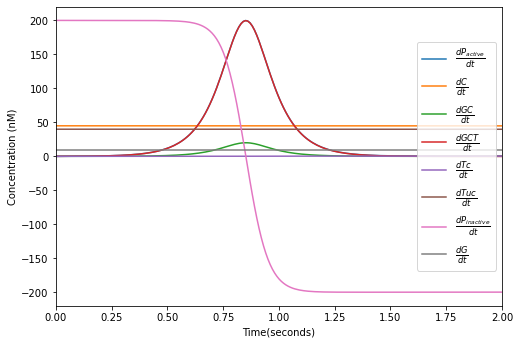

In [187]:

plt.rcParams["figure.figsize"] = (8,5.5)

plt.plot(t, m.T)
plt.legend(["$\\frac{dP_{active}}{dt}$", '$\\frac{dC}{dt}$',
            '$\\frac{dGC}{dt}$','$\\frac{dGCT}{dt}$','$\\frac{dTc}{dt}$',
            '$\\frac{dTuc}{dt}$','$\\frac{dP_{inactive}}{dt}$',
            '$\\frac{dG}{dt}$'],fontsize = 'large',loc='right')#bbox_to_anchor=(1, 0.5))
plt.ylabel("Concentration (nM)")
plt.xlabel("Time(seconds)")
plt.xlim(0,2)
#plt.savefig('images/modeling_poc_V2.png',dpi = 300)
plt.show()

## New Model

In [4]:
def syst2(t,z,param):
    
    Tu,Pa,Pi,Tc = z
    
    GC,K1,K2,K3,K4,Km = param  
    
    dTudt = -(K1*GC*Tu)
    
    dPadt = (K3*Tu*GC*Pi)/(Km+Tu)
    
    dPidt = -dPadt
    
    dTcdt = (K4*Tu*GC)/(Km+Tu)
    
    return [dTudt,dPadt,dPidt,dTcdt]

In [5]:
Tu = 50
Pa = 0.001
Pi = 100
Tc = 0.001
GC = 0.1 
K1 = 0.1
K2 = 0.05
K3 = 10
K4 = 1
Km = 500

z = [Tu,Pa,Pi,Tc]
param  = [GC,K1,K2,K3,K4,Km]
t = np.linspace(0, 100, 1000)

sol_2 =  solve_ivp(syst2, t_span=[0, t.max()], y0=z, dense_output=True, atol=1e-8, rtol=1e-8,args=([param]),method="LSODA")
d = sol_2.sol(t)

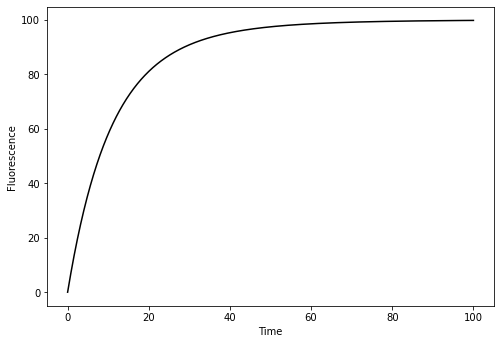

In [17]:
plt.rcParams["figure.figsize"] = (8,5.5)

plt.plot(t, d.T)
plt.legend(['Tu','Pa','Pi','Tc'])
plt.ylabel("Concentration (nM)")
plt.xlabel("Time(seconds)")
#plt.savefig('images/modeling_poc_MM.png',dpi = 300)
plt.show()

#### Only the cut target

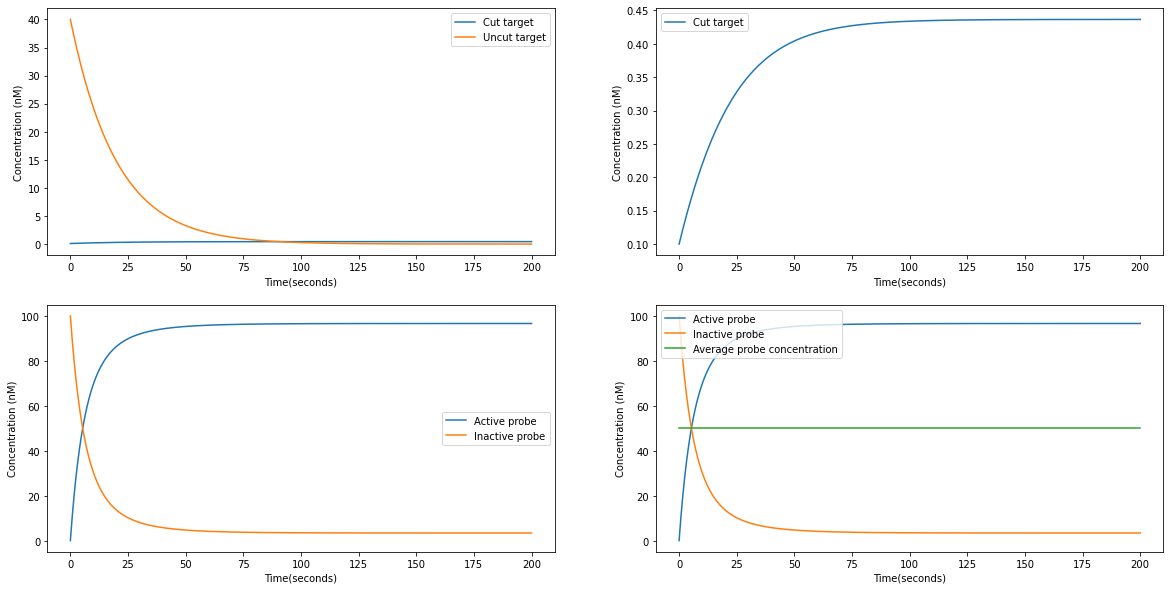

In [458]:
Tc = [d.T[i][3] for i in range(len(d.T))]
Tu = [d.T[i][0] for i in range(len(d.T))]
Pa = [d.T[i][1] for i in range(len(d.T))]
Pi = [d.T[i][2] for i in range(len(d.T))]

fig,ax = plt.subplots(2,2)
fig.set_size_inches(20,10)
ax[0][0].plot(t,Tc, label = "Cut target")
ax[0][0].plot(t,Tu, label = "Uncut target")
ax[0][1].plot(t,Tc, label = "Cut target")

ax[1][0].plot(t,Pa, label = "Active probe")
ax[1][0].plot(t,Pi, label = "Inactive probe")
t_tot = [(Pa[i]+Pi[i])/2 for i in range(len(Tu))]
ax[1][1].plot(t,Pa, label = "Active probe")
ax[1][1].plot(t,Pi, label = "Inactive probe")
ax[1][1].plot(t,t_tot, label = "Average probe concentration")


for ax in ax:
    for ax in ax:
        
        ax.set_ylabel("Concentration (nM)")
        ax.set_xlabel("Time(seconds)")
        ax.legend()
  

plt.savefig("images/modeling_MM_presentation.png",dpi =300)
plt.show()

## Verification of the results

### Check that the average probe concentration is constant

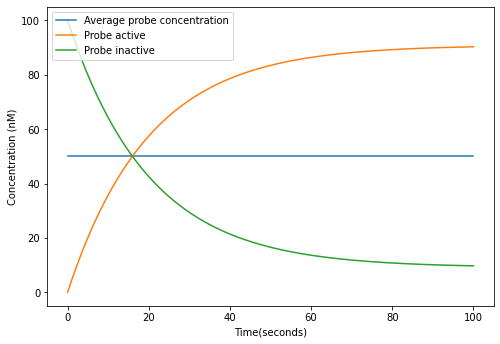

In [330]:
Tu = [d.T[i][0] for i in range(len(d.T))]
Pa = [d.T[i][1] for i in range(len(d.T))]
Pi = [d.T[i][2] for i in range(len(d.T))]
Tc = [d.T[i][3] for i in range(len(d.T))]

t_tot = [(Pa[i]+Pi[i])/2 for i in range(len(Tu))]
plt.plot(t,t_tot, label = "Average probe concentration")
plt.plot(t,Pa, label = "Probe active")
plt.plot(t,Pi, label = "Probe inactive")
plt.legend(loc="best")
plt.ylabel("Concentration (nM)")
plt.xlabel("Time(seconds)")
#plt.savefig("images/total_probe_concentration.png",dpi=300)
plt.show()

### Check that the average target concentration is constant

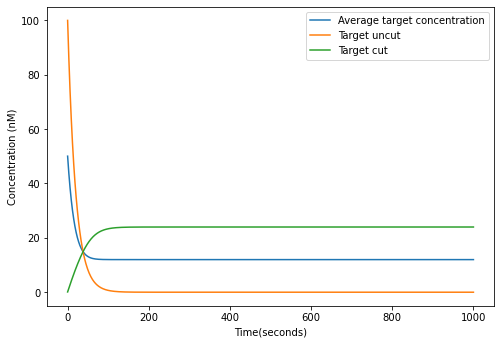

In [332]:
t = np.linspace(0, 1000, 1000)

sol_2 =  solve_ivp(syst2, t_span=[0, t.max()], y0=z, dense_output=True, atol=1e-8, rtol=1e-8,args=([param]),method="LSODA")
d = sol_2.sol(t)

Tu = [d.T[i][0] for i in range(len(d.T))]
Tc = [d.T[i][3] for i in range(len(d.T))]

t_tot = [(Tu[i]+Tc[i])/2 for i in range(len(Tu))]
plt.plot(t,t_tot, label = "Average target concentration")
plt.plot(t,Tu, label = "Target uncut")
plt.plot(t,Tc, label = "Target cut")
plt.legend(loc="best")
plt.ylabel("Concentration (nM)")
plt.xlabel("Time(seconds)")
#plt.ylim(0,2.5)
#plt.savefig("images/total_target_concentration.png",dpi=300)
plt.show()

### Test of the parameter space

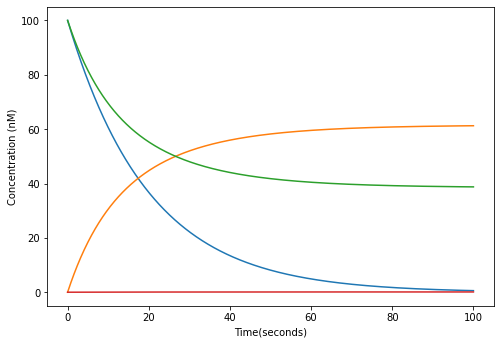

In [393]:
z = [100,0.1,100,0.1]

t = np.linspace(0, 100, 1000)
counter = 0
for i in np.linspace(100,1000,1):
    param  = [GC,K1,K2,K3,K4,1000]
    sol_2 =  solve_ivp(syst2, t_span=[0, t.max()], y0=z, dense_output=True, atol=1e-8, rtol=1e-8,args=([param]),method="LSODA")
    d = sol_2.sol(t)
    
    plt.plot(t,d.T)
    plt.ylabel("Concentration (nM)")
    plt.xlabel("Time(seconds)")
plt.show()

        




In [349]:
with imageio.get_writer('images/movie_parameter_space.gif', mode='I') as writer:
    for i in range(200,1600):
        direct = "C:/Users/nessl/Documents/iGEM/iGEM/images/gif/"
        filename='parameter_'+str(i)+'.png'
        image = imageio.imread(direct+filename)
        writer.append_data(image)
        os.remove('images/gif/'+ filename)

## Error calculation and minimization

In [230]:
def error(param,obs):
    
    times = np.linspace(0,500,97)
    t = np.linspace(0,500,500)
    
    sol = solve_ivp(syst,t_span =[0, times.max()], y0= z , args =([param]),t_eval=times,method='DOP853',dense_output=True,rtol=1e-8,atol=1e-8)
    
    z = sol.sol(times)
    
    err = []
        
    for i in range(len(z.tolist()[0])):
        err.append((obs[i]-z.tolist()[0][i])**2)    
    
    erro = np.sum(err)

    return erro

In [ ]:
res = minimize(error, param, args=(obs))